## Data / Package Import 

In [1]:
import pandas as pd
import os
from Bio import Affy
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, GRU, Layer, Add, GlobalAveragePooling1D, Conv1D, ReLU
from sklearn.model_selection import KFold, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Dense, Dropout, Activation, LeakyReLU, Reshape
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, cross_val_score
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from hyperopt.pyll.base import scope
import scipy.stats as stats
from keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras import backend as K
from transformers import BertTokenizer
import torch
from tensorflow.keras.utils import to_categorical
from torch.utils.data import Dataset
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from accelerate import DataLoaderConfiguration
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.regularizers import l1
from bayes_opt import BayesianOptimization
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from boruta import BorutaPy
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from boruta import BorutaPy
from skrebate import ReliefF
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.svm import SVC

C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## AMGM and Cosine Feature Selection

In [2]:
def calculate_amgm(X):
    """
    Calculate AMGM for each feature (row) in the dataset X.
    
    Parameters:
    X (numpy array): The input data array with shape (n_features, n_samples)
    
    Returns:
    amgm_values (numpy array): The AMGM values for each feature (row)
    """
    N = X.shape[1]
    
    exp_X = np.exp(X)
    amgm_values = (np.mean(exp_X, axis=1)) / (np.exp(np.mean(X, axis=1)))
    
    return amgm_values

In [3]:
def filter_redundant_features(X, relevant_indices, threshold=0.9):
    relevant_features = X[relevant_indices, :]
    cos_sim_matrix = cosine_similarity(relevant_features)
    
    to_keep = []
    to_drop = set()
    for i in range(cos_sim_matrix.shape[0]):
        if i not in to_drop:
            to_keep.append(relevant_indices[i])
            for j in range(i + 1, cos_sim_matrix.shape[0]):
                if cos_sim_matrix[i, j] > threshold:
                    to_drop.add(relevant_indices[j])
    return to_keep

## Autoencoder Feature Selection with Lasso Regression

In [4]:
def create_feature_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)  # Encoder part
    decoded = Dense(input_dim, activation='sigmoid')(encoded)  # Decoder part
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

In [5]:
def apply_l1_feature_selection(X, y, alpha=0.01, target_features=100):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    model = SelectFromModel(lasso, prefit=True, max_features=target_features)
    X_reduced = model.transform(X)
    selected_indices = model.get_support(indices=True)
    return X_reduced, selected_indices

## Initial Deep Autoencoder

In [36]:
def create_deep_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(input_dim // 2, input_shape=(input_dim,), activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 4, activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 2, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(3, activation='softmax'))  # Final classification layer with 3 units
    return model

In [37]:
def cyclical_learning_rate(epoch, lr):
    base_lr = 0.001
    max_lr = 0.006
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [38]:
input_file_path = 'C:/Research_Summer/FinalizedLymphomaData.csv' #Change for different files

In [39]:
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]  # SNP genotype data
case_control_info = df.iloc[-1, :]  # Case/Control row

C:\Users\colte\AppData\Local\Temp\ipykernel_23744\562430524.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [40]:
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [41]:
amgm_values = calculate_amgm(X)

In [42]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [43]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [100934  45278  16458  85061  26727 190171 103208 104177 147604 196537]
Top AMGM values: [1.02078682 1.0207938  1.02079811 1.02080217 1.02080217 1.02080337
 1.02080744 1.020811   1.02082079 1.02083496]


In [44]:
y = case_control_info.map({'Type GCB Lymphoma': 0, 'Type ABC Lymphoma': 1, 'Other / Type 3 Lymphoma': 2}).values

In [45]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [46]:
X_selected = X[selected_indices, :].T 

In [47]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [49]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [50]:
y_train_encoded = to_categorical(y_train, num_classes=3)
y_val_encoded = to_categorical(y_val, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

In [51]:
input_dim = X_train.shape[1]
model = create_deep_autoencoder(input_dim)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
model.summary()

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_125 (Dense)                    │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_182 (Dropout)                │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_126 (Dense)                    │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_183 (Dropout)                │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_127 (Dense)                    │ (None, 50)                  │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_128 (Dense)                    │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_129 (Dense)                    │ (None, 3)                   │             303 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,028 (50.89 KB)

 Trainable params: 13,028 (50.89 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
clr = LearningRateScheduler(cyclical_learning_rate)
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_val, y_val_encoded), callbacks=[clr])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.2723 - loss: 1.4021 - val_accuracy: 0.6000 - val_loss: 1.0274 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4718 - loss: 1.1495 - val_accuracy: 0.6000 - val_loss: 0.9005 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5052 - loss: 0.9565 - val_accuracy: 0.6000 - val_loss: 0.8656 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4976 - loss: 1.0882 - val_accuracy: 0.6000 - val_loss: 0.8581 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4691 - loss: 1.0932 - val_accuracy: 0.6000 - val_loss: 0.8525 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4840 - loss: 1.0393 - val_accuracy: 0.6000 - val_loss: 0.8469 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4645 - loss: 1.0105 - val_accuracy: 0.6000 - val

In [57]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_encoded, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


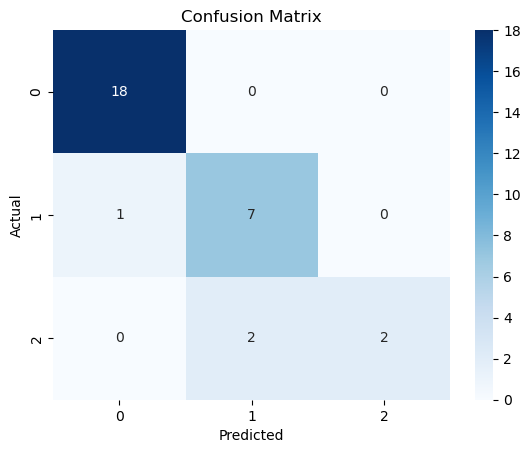

In [58]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [59]:
accuracy = accuracy_score(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred, average='weighted')  # Use 'weighted' for multi-class f1 score

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

for i in range(3):  # Assuming 3 classes
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp
    fp = cm[:, i].sum() - tp
    tn = cm.sum() - (tp + fn + fp)
    
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    print(f"Class {i} - Sensitivity: {sensitivity}, Specificity: {specificity}")

Accuracy: 0.9
F1 Score: 0.8922805158099276
Class 0 - Sensitivity: 1.0, Specificity: 0.9166666666666666
Class 1 - Sensitivity: 0.875, Specificity: 0.9090909090909091
Class 2 - Sensitivity: 0.5, Specificity: 1.0


## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization)

In [60]:
input_file_path = 'C:/Research_Summer/FinalizedLymphomaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_23744\2187115470.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [61]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [62]:
amgm_values = calculate_amgm(X)

In [63]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [64]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [100934  45278  16458  85061  26727 190171 103208 104177 147604 196537]
Top AMGM values: [1.02078682 1.0207938  1.02079811 1.02080217 1.02080217 1.02080337
 1.02080744 1.020811   1.02082079 1.02083496]


In [65]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [66]:
X_selected = X[selected_indices, :].T

In [67]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [68]:
y = case_control_info.map({'Type GCB Lymphoma': 0, 'Type ABC Lymphoma': 1, 'Other / Type 3 Lymphoma': 2}).values

In [28]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [70]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(3, activation='softmax'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [71]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [72]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
    conf_matrix = confusion_matrix(y, y_pred)
    sensitivity = np.mean([conf_matrix[i, i] / (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) if (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) != 0 else 0 for i in range(3)])
    specificity = np.mean([np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1)) / (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) if (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) != 0 else 0 for i in range(3)])

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}


In [73]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

Accuracy: 0.9054054054054054, F1 Score: 0.9035765255910783, Sensitivity: 0.8876173254111771, Specificity: 22.366666666666664
Accuracy: 0.6283783783783784, F1 Score: 0.5574944842801985, Sensitivity: 0.43890467579436837, Specificity: 2.4194139194139193
Accuracy: 0.9121621621621622, F1 Score: 0.9101845748187211, Sensitivity: 0.8944200464996125, Specificity: 27.507936507936506
Accuracy: 0.8648648648648649, F1 Score: 0.8632116965450298, Sensitivity: 0.8296564195298372, Specificity: 13.666666666666666
Accuracy: 0.8783783783783784, F1 Score: 0.8764980440967284, Sensitivity: 0.813670024972014, Specificity: 16.95         
Accuracy: 0.8918918918918919, F1 Score: 0.8912740922346585, Sensitivity: 0.8542839920778439, Specificity: 17.445238095238093
Accuracy: 0.5675675675675675, F1 Score: 0.45940425719837485, Sensitivity: 0.36734693877551017, Specificity: 1.6666666666666667
Accuracy: 0.6824324324324325, F1 Score: 0.6464726486198573, Sensitivity: 0.5473434943597693, Specificity: 8.766666666666667
Acc

In [74]:
print("Best parameters found: ", best)
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best parameters found:  {'batch_size': 16.0, 'dropout_rate': 0.6587818781540193, 'epochs': 200.0, 'learning_rate': 0.00026114185914985125, 'neurons1': 128.0, 'neurons2': 32.0}
Best Accuracy: 0.9391891891891891
Best F1 Score: 0.9386115248872979
Best Specificity: 36.25
Best Sensitivity: 0.9117669852751228


In [75]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

In [76]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Ensure all data is cast to float32
        X_train = X_train.astype(np.float32)
        X_val = X_val.astype(np.float32)
        
        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        model = create_deep_autoencoder(
            input_dim=X_train.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )

        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for the current fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)

    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nCross-Validation Performance:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average F1 Score: {avg_f1}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

In [77]:
train_and_evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Cross-Validation Performance:
Average Accuracy: 0.9528735632183908
Average F1 Score: 0.9518929481348272
Average Sensitivity: 0.9331168831168831
Average Specificity: 0.9704306220095693


In [78]:
print("\nBest Hyperparameters:")
print(f"Neurons in first layer: {int(best['neurons1'])}")
print(f"Neurons in second layer: {int(best['neurons2'])}")
print(f"Dropout rate: {best['dropout_rate']}")
print(f"Learning rate: {best['learning_rate']}")
print(f"Number of epochs: {int(best['epochs'])}")
print(f"Batch size: {int(best['batch_size'])}")


Best Hyperparameters:
Neurons in first layer: 128
Neurons in second layer: 32
Dropout rate: 0.6587818781540193
Learning rate: 0.00026114185914985125
Number of epochs: 200
Batch size: 16


## CNN with Bayesian Optimization

In [79]:
input_file_path = 'C:/Research_Summer/FinalizedLymphomaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_23744\2187115470.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [80]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Type GCB Lymphoma': 0, 'Type ABC Lymphoma': 1, 'Other / Type 3 Lymphoma': 2}).values
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [81]:
amgm_values = calculate_amgm(X)

In [82]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [83]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [84]:
X_selected = X[selected_indices, :].T

In [85]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [86]:
X_selected = X_selected.reshape(X_selected.shape[0], X_selected.shape[1], 1)  # Add a channel dimension

In [87]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [88]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001, num_classes=3):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [89]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [90]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [91]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            num_classes=3
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [92]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step                                                

Iteration Results - Accuracy: 0.6010683760683762, F1 Score: 0.6092187827788204, Sensitivity: 0.5778350371487627, Specificity: 0.8168124754527949
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step                                         

In [93]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 16, 'dropout_rate': 0.40938076466917594, 'epochs': 40, 'filters': 64, 'kernel_size': 4, 'learning_rate': 0.007426385379885366}


In [95]:
def k_fold_cross_validation(X, y, best_params, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_index, val_index in kfold.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        input_dim = X_train.shape[1]
        model = create_cnn_model(
            input_shape=(input_dim, 1),
            filters=best_params['filters'],
            kernel_size=best_params['kernel_size'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate'],
            num_classes=3
        )
        model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    print(f"Avg Accuracy: {avg_accuracy}")
    print(f"Avg F1 Score: {avg_f1}")
    print(f"Avg Sensitivity: {avg_sensitivity}")
    print(f"Avg Specificity: {avg_specificity}")

    return avg_accuracy, avg_f1, avg_sensitivity, avg_specificity

In [96]:
avg_accuracy, avg_f1, avg_sensitivity, avg_specificity = k_fold_cross_validation(X_selected, y, best_params, n_splits=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Avg Accuracy: 0.8386206896551723
Avg F1 Score: 0.8048991480448656
Avg Sensitivity: 0.750021645021645
Avg Specificity: 0.9051094130041498


## FNN with Bayesian Optimization

In [97]:
input_file_path = 'C:/Research_Summer/FinalizedLymphomaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Type GCB Lymphoma': 0, 'Type ABC Lymphoma': 1, 'Other / Type 3 Lymphoma': 2}).values
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

C:\Users\colte\AppData\Local\Temp\ipykernel_23744\3097528564.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [98]:
amgm_values = calculate_amgm(X)
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [99]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 
X_selected = X[selected_indices, :].T
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [101]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [102]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [103]:
def objective(params):
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [104]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 0.9936140179634094, Params: {'batch_size': 64, 'dropout_rate': 0.164306648271778, 'epochs': 50, 'learning_rate': 2.9874088200592174e-05, 'num_layers': 4, 'units': 224}
Iteration - Loss: 0.2648376226425171, Params: {'batch_size': 96, 'dropout_rate': 0.14942654898642732, 'epochs': 70, 'learning_rate': 0.00021295872414717635, 'num_layers': 5, 'units': 192}
Iteration - Loss: 1.091002106666565, Params: {'batch_size': 80, 'dropout_rate': 0.25471344834942233, 'epochs': 90, 'learning_rate': 1.9959053242300136e-05, 'num_layers': 4, 'units': 160}
Iteration - Loss: 0.4344571530818939, Params: {'batch_size': 112, 'dropout_rate': 0.16837662508206286, 'epochs': 70, 'learning_rate': 0.0003271759876136715, 'num_layers': 2, 'units': 224}
Iteration - Loss: 0.5463016629219055, Params: {'batch_size': 48, 'dropout_rate': 0.22008203304652915, 'epochs': 140, 'learning_rate': 0.00013798533445968749, 'num_layers': 5, 'units': 224}
Iteration - Loss: 0.47936248779296875, Params: {'batch_size': 

In [105]:
best_params = {
    'num_layers': int(best['num_layers']),
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.3560527302676636, 'learning_rate': 0.009271248718442229, 'epochs': 120, 'batch_size': 112}


In [106]:
def evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = create_fnn_model(
            input_dim=X_train.shape[1],
            num_layers=best_params['num_layers'],
            units=best_params['units'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nFinal Model Performance with K-Fold Cross-Validation:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Final Model Performance with K-Fold Cross-Validation:
Accuracy: 0.8381609195402298
F1 Score: 0.832445668421788
Sensitivity: 0.8093458393458395
Specificity: 0.9165712377291324


## Stacked Autoencoder & FNN Model

In [107]:
input_file_path = 'C:/Research_Summer/FinalizedLymphomaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]
case_control_info = df.iloc[-1, :]
y = case_control_info.map({'Type GCB Lymphoma': 0, 'Type ABC Lymphoma': 1, 'Other / Type 3 Lymphoma': 2}).values.astype(np.float32)
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

C:\Users\colte\AppData\Local\Temp\ipykernel_23744\2808319800.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [108]:
amgm_values = calculate_amgm(X)
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [100934  45278  16458  85061  26727 190171 103208 104177 147604 196537]
Top AMGM values: [1.0207862 1.0207932 1.0207977 1.0208029 1.020803  1.0208036 1.020809
 1.0208113 1.0208215 1.0208341]


In [109]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 
X_selected = X[selected_indices, :].T
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
def ensure_float32(data):
    return data.astype(np.float32)

In [110]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [111]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [112]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate, num_classes):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [113]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [114]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0,
        num_classes=3  # Set to the number of classes
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [115]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [116]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step            

In [117]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate'],
            num_classes=3  # Set to the number of classes
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val)
        y_val_pred_binary = np.argmax(y_val_pred, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred_binary, num_classes=3)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")


In [118]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Final Model - Accuracy: 0.8297101449275364
Final Model - F1 Score: 0.8257479130884791
Final Model - Sensitivity: 0.7773665223665224
Final Model - Specificity: 0.9009594666163517


## Deep Autoencoder with L1 Feature Selection

In [119]:
def create_deep_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(input_dim // 2, input_shape=(input_dim,), activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 4, activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 2, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(3, activation='softmax'))  # Final classification layer with 3 units
    return model

In [120]:
def cyclical_learning_rate(epoch, lr):
    base_lr = 0.001
    max_lr = 0.006
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [6]:
input_file_path = 'C:/Research_Summer/FinalizedLymphomaData.csv' #Change for different files

In [7]:
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]  # SNP genotype data
case_control_info = df.iloc[-1, :]  # Case/Control row

C:\Users\colte\AppData\Local\Temp\ipykernel_28496\562430524.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [8]:
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [9]:
y = case_control_info.map({'Type GCB Lymphoma': 0, 'Type ABC Lymphoma': 1, 'Other / Type 3 Lymphoma': 2}).values

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
X_scaled = X_scaled.T

In [12]:
input_dim = X_scaled.shape[1]
encoding_dim = 1000

In [13]:
autoencoder, encoder = create_feature_autoencoder(input_dim, encoding_dim)
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.2506 - val_loss: 1.2201
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.2221 - val_loss: 1.2430
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.0517 - val_loss: 1.2490
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9945 - val_loss: 1.2495
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9969 - val_loss: 1.2495
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9939 - val_loss: 1.2495
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9906 - val_loss: 1.2495
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9872 - val_loss: 1.2495
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9839 - val_loss: 1.2494
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9810 - val_loss: 1.2494
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9782 - val_loss: 1.2494
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9756 - val_loss: 1.2493
Epoch 13/50
1/1 ━━━━━━━━━

In [14]:
X_encoded = encoder.predict(X_scaled)
print(f"Shape of encoded features: {X_encoded.shape}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Shape of encoded features: (148, 1000)


In [15]:
target_features = 200  # Target number of features
X_final, selected_indices_l1 = apply_l1_feature_selection(X_encoded, y, alpha=0.005, target_features=target_features)
print(f"Shape after L1-based Feature Selection: {X_final.shape}")

Shape after L1-based Feature Selection: (148, 179)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.886e-01, tolerance: 7.548e-03
  model = cd_fast.enet_coordinate_descent(


In [16]:
X_final.shape

(148, 179)

In [132]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [133]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [134]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [135]:
y_train_encoded = to_categorical(y_train, num_classes=3)
y_val_encoded = to_categorical(y_val, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

In [136]:
input_dim = X_train.shape[1]
model = create_deep_autoencoder(input_dim)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [137]:
model.summary()

Model: "sequential_267"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1573 (Dense)                   │ (None, 86)                  │          14,964 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_920 (Dropout)                │ (None, 86)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1574 (Dense)                   │ (None, 43)                  │           3,741 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_921 (Dropout)                │ (None, 43)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1575 (Dense)                   │ (None, 86)                  │           3,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1576 (Dense)                   │ (None, 173)                 │          15,051 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1577 (Dense)                   │ (None, 3)                   │             522 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,062 (148.68 KB)

 Trainable params: 38,062 (148.68 KB)

 Non-trainable params: 0 (0.00 B)

In [138]:
clr = LearningRateScheduler(cyclical_learning_rate)
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_val, y_val_encoded), callbacks=[clr])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3544 - loss: 1.2307 - val_accuracy: 0.6000 - val_loss: 0.8535 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4502 - loss: 1.0485 - val_accuracy: 0.6000 - val_loss: 0.8378 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4674 - loss: 1.1148 - val_accuracy: 0.6000 - val_loss: 0.8344 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4720 - loss: 1.0738 - val_accuracy: 0.6000 - val_loss: 0.8492 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5323 - loss: 1.0214 - val_accuracy: 0.5333 - val_loss: 0.9027 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4689 - loss: 1.0274 - val_accuracy: 0.5333 - val_loss: 0.9433 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4960 - loss: 0.9837 - val_accuracy: 0.6000 - v

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_encoded, axis=1)

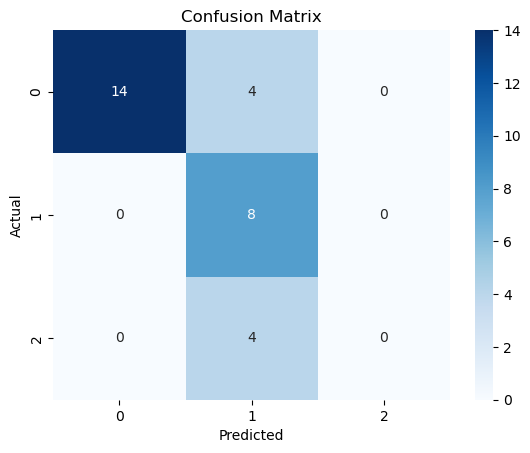

In [141]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [142]:
accuracy = accuracy_score(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred, average='weighted')  # Use 'weighted' for multi-class f1 score

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

for i in range(3):  # Assuming 3 classes
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp
    fp = cm[:, i].sum() - tp
    tn = cm.sum() - (tp + fn + fp)
    
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    print(f"Class {i} - Sensitivity: {sensitivity}, Specificity: {specificity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.7333333333333333
F1 Score: 0.7027777777777777
Class 0 - Sensitivity: 0.7777777777777778, Specificity: 1.0
Class 1 - Sensitivity: 1.0, Specificity: 0.6363636363636364
Class 2 - Sensitivity: 0.0, Specificity: 1.0


## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization) - L1 Feature Selection

In [143]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(3, activation='softmax'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [144]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [145]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

In [146]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [147]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
    conf_matrix = confusion_matrix(y, y_pred)
    sensitivity = np.mean([conf_matrix[i, i] / (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) if (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) != 0 else 0 for i in range(3)])
    specificity = np.mean([np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1)) / (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) if (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) != 0 else 0 for i in range(3)])

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}


In [148]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

Accuracy: 0.9256756756756757, F1 Score: 0.9261984554133063, Sensitivity: 0.9080254886764833, Specificity: 28.61111111111111
Accuracy: 0.8513513513513513, F1 Score: 0.8354907743185304, Sensitivity: 0.7148282097649186, Specificity: 21.17222222222222
Accuracy: 0.8040540540540541, F1 Score: 0.7988546177412233, Sensitivity: 0.6822397313355723, Specificity: 11.55324074074074
Accuracy: 0.5337837837837838, F1 Score: 0.3715323252768187, Sensitivity: 0.3333333333333333, Specificity: 0.0          
Accuracy: 0.7094594594594594, F1 Score: 0.654265307491114, Sensitivity: 0.5200680272108843, Specificity: 2.0285087719298245
Accuracy: 0.8513513513513513, F1 Score: 0.8500065638329792, Sensitivity: 0.77189787307328, Specificity: 16.316239316239315
Accuracy: 0.8918918918918919, F1 Score: 0.8895375122695317, Sensitivity: 0.8444200464996126, Specificity: 19.0         
Accuracy: 0.7837837837837838, F1 Score: 0.7286393536393536, Sensitivity: 0.5876173254111771, Specificity: 2.9956709956709955
Accuracy: 0.9391

In [149]:
print("Best parameters found: ", best)
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best parameters found:  {'batch_size': 48.0, 'dropout_rate': 0.5929342681684266, 'epochs': 150.0, 'learning_rate': 0.0005063763277206743, 'neurons1': 192.0, 'neurons2': 96.0}
Best Accuracy: 0.9391891891891891
Best F1 Score: 0.9385437742417148
Best Specificity: 37.083333333333336
Best Sensitivity: 0.921630930853354


In [150]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

In [151]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Ensure all data is cast to float32
        X_train = X_train.astype(np.float32)
        X_val = X_val.astype(np.float32)
        
        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        model = create_deep_autoencoder(
            input_dim=X_train.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )

        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for the current fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)

    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nCross-Validation Performance:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average F1 Score: {avg_f1}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

In [152]:
train_and_evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Cross-Validation Performance:
Average Accuracy: 0.9390804597701148
Average F1 Score: 0.9391766051568909
Average Sensitivity: 0.920995670995671
Average Specificity: 0.9670801946591421


## CNN with Bayesian Optimization - L1 Feature Selection

In [186]:
X_selected = X_final.reshape(X_final.shape[0], X_final.shape[1], 1)  # Add a channel dimension

In [187]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [188]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001, num_classes=3):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [189]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [190]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            num_classes=3
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [191]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step                                                

Iteration Results - Accuracy: 0.5158119658119659, F1 Score: 0.45304558565428127, Sensitivity: 0.39808339808339804, Specificity: 0.7199207911110025
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step                                       

In [192]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.21571383917152637, 'epochs': 50, 'filters': 96, 'kernel_size': 2, 'learning_rate': 0.001544077482346001}


In [193]:
def k_fold_cross_validation(X, y, best_params, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_index, val_index in kfold.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        input_dim = X_train.shape[1]
        model = create_cnn_model(
            input_shape=(input_dim, 1),
            filters=best_params['filters'],
            kernel_size=best_params['kernel_size'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate'],
            num_classes=3
        )
        model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    print(f"Avg Accuracy: {avg_accuracy}")
    print(f"Avg F1 Score: {avg_f1}")
    print(f"Avg Sensitivity: {avg_sensitivity}")
    print(f"Avg Specificity: {avg_specificity}")

    return avg_accuracy, avg_f1, avg_sensitivity, avg_specificity

In [194]:
avg_accuracy, avg_f1, avg_sensitivity, avg_specificity = k_fold_cross_validation(X_selected, y, best_params, n_splits=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Avg Accuracy: 0.6222988505747126
Avg F1 Score: 0.5581481751435672
Avg Sensitivity: 0.4593458393458394
Avg Specificity: 0.7507098398677345


## FNN with Bayesian Optimization - L1 Feature Selection

In [195]:
X_selected = X_final.reshape((X_final.shape[0], X_final.shape[1], 1))

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [197]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [198]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [199]:
def objective(params):
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [200]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 4.7889556884765625, Params: {'batch_size': 80, 'dropout_rate': 0.14180316114671243, 'epochs': 60, 'learning_rate': 0.0023056531411399525, 'num_layers': 2, 'units': 64}
Iteration - Loss: 4.85131311416626, Params: {'batch_size': 112, 'dropout_rate': 0.18258695710375222, 'epochs': 100, 'learning_rate': 0.0025529335587337132, 'num_layers': 5, 'units': 160}
Iteration - Loss: 8.079543113708496, Params: {'batch_size': 48, 'dropout_rate': 0.13528570451020233, 'epochs': 70, 'learning_rate': 4.922335960876748e-05, 'num_layers': 3, 'units': 160}
Iteration - Loss: 7.280603408813477, Params: {'batch_size': 96, 'dropout_rate': 0.32579513723532627, 'epochs': 50, 'learning_rate': 0.0002854735655856722, 'num_layers': 3, 'units': 64}
Iteration - Loss: 1.9918895959854126, Params: {'batch_size': 64, 'dropout_rate': 0.46720698518305326, 'epochs': 50, 'learning_rate': 0.0037693471764592597, 'num_layers': 3, 'units': 224}
Iteration - Loss: 1.308919906616211, Params: {'batch_size': 96, 'drop

In [201]:
best_params = {
    'num_layers': int(best['num_layers']),
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'num_layers': 5, 'units': 160, 'dropout_rate': 0.1025461353255754, 'learning_rate': 0.007333272799075298, 'epochs': 140, 'batch_size': 16}


In [202]:
def evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = create_fnn_model(
            input_dim=X_train.shape[1],
            num_layers=best_params['num_layers'],
            units=best_params['units'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nFinal Model Performance with K-Fold Cross-Validation:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Final Model Performance with K-Fold Cross-Validation:
Accuracy: 0.7898850574712644
F1 Score: 0.7716619414731938
Sensitivity: 0.6846801346801347
Specificity: 0.8699904724904725


## Stacked Autoencoder & FNN Model - L1 Feature Selection

In [17]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [18]:
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [19]:
def ensure_float32(data):
    return data.astype(np.float32)

In [20]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [21]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [22]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate, num_classes):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0,
        num_classes=3  # Set to the number of classes
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [24]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [25]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                

  0%|                                                                           | 0/20 [00:03<?, ?trial/s, best loss=?]WARNING:tensorflow:5 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001B20FF33240> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoi

In [26]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate'],
            num_classes=3  # Set to the number of classes
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val)
        y_val_pred_binary = np.argmax(y_val_pred, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred_binary, num_classes=3)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")


In [29]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Final Model - Accuracy: 0.47536231884057967
Final Model - F1 Score: 0.45263866609818637
Final Model - Sensitivity: 0.3646572871572872
Final Model - Specificity: 0.715486136483579


## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization) - 1500 SNPs

In [30]:
input_file_path = 'C:/Research_Summer/FinalizedLymphomaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_28496\2187115470.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [31]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [32]:
amgm_values = calculate_amgm(X)

In [33]:
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [34]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [173449  52078 156129  95359  76333 194088 179643  74118 171266  58210]
Top AMGM values: [1.01096861 1.01096861 1.01096898 1.01096938 1.01097004 1.01097012
 1.01097138 1.01097189 1.01097253 1.01097253]


In [35]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 

In [36]:
X_selected = X[selected_indices, :].T

In [37]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [38]:
y = case_control_info.map({'Type GCB Lymphoma': 0, 'Type ABC Lymphoma': 1, 'Other / Type 3 Lymphoma': 2}).values

In [39]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [40]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(3, activation='softmax'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [41]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [42]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
    conf_matrix = confusion_matrix(y, y_pred)
    sensitivity = np.mean([conf_matrix[i, i] / (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) if (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) != 0 else 0 for i in range(3)])
    specificity = np.mean([np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1)) / (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) if (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) != 0 else 0 for i in range(3)])

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}


In [43]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 0.0                                                       
Accuracy: 0.9932432432432432, F1 Score: 0.9932296622629242, Sensitivity: 0.9931972789115647, Specificity: 22.666666666666668
Accuracy: 0.722972972972973, F1 Score: 0.6518784057794902, Sensitivity: 0.7210884353741497, Specificity: 0.22764227642276424
Accuracy: 0.9662162162162162, F1 Score: 0.9652377017405972, Sensitivity: 0.926530612244898, Specificity: 30.583333333333332
Accuracy: 0.9932432432432432, F1 Score: 0.9932296622629242, Sensitivity: 0.9931972789115647, Specificity: 22.666666666666668
Accuracy: 0.5540540540540541, F1 Score: 0.5627310002310001, Sensitivity: 0.5942306036338586, Specificity: 1.0166666666666666
Accuracy: 0.9662162162162162, F1 Score: 0.9659127329083469, Sensitivity: 0.9462585034013605, Specificity: 38.083333333333336
Accuracy: 0.527027027027027, F1 Score: 0.4936827236719478, Sensitivity: 0.4618057349522087, Specificity: 1.6089743589743588
Accurac

In [44]:
print("Best parameters found: ", best)
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best parameters found:  {'batch_size': 96.0, 'dropout_rate': 0.534408434294422, 'epochs': 150.0, 'learning_rate': 0.0037928119709509, 'neurons1': 128.0, 'neurons2': 32.0}
Best Accuracy: 1.0
Best F1 Score: 1.0
Best Specificity: 0.0
Best Sensitivity: 1.0


In [45]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

In [46]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Ensure all data is cast to float32
        X_train = X_train.astype(np.float32)
        X_val = X_val.astype(np.float32)
        
        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        model = create_deep_autoencoder(
            input_dim=X_train.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )

        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for the current fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)

    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nCross-Validation Performance:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average F1 Score: {avg_f1}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

In [47]:
train_and_evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Cross-Validation Performance:
Average Accuracy: 0.9188505747126436
Average F1 Score: 0.9097863328220435
Average Sensitivity: 0.8284343434343434
Average Specificity: 0.9474027239816714


In [48]:
print("\nBest Hyperparameters:")
print(f"Neurons in first layer: {int(best['neurons1'])}")
print(f"Neurons in second layer: {int(best['neurons2'])}")
print(f"Dropout rate: {best['dropout_rate']}")
print(f"Learning rate: {best['learning_rate']}")
print(f"Number of epochs: {int(best['epochs'])}")
print(f"Batch size: {int(best['batch_size'])}")


Best Hyperparameters:
Neurons in first layer: 128
Neurons in second layer: 32
Dropout rate: 0.534408434294422
Learning rate: 0.0037928119709509
Number of epochs: 150
Batch size: 96


## CNN with Bayesian Optimization - 1500 SNPs

In [49]:
input_file_path = 'C:/Research_Summer/FinalizedLymphomaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_28496\2187115470.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [50]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Type GCB Lymphoma': 0, 'Type ABC Lymphoma': 1, 'Other / Type 3 Lymphoma': 2}).values
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [51]:
amgm_values = calculate_amgm(X)

In [52]:
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [53]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 

In [54]:
X_selected = X[selected_indices, :].T

In [55]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [56]:
X_selected = X_selected.reshape(X_selected.shape[0], X_selected.shape[1], 1)  # Add a channel dimension

In [57]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [58]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001, num_classes=3):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [59]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [60]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [61]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            num_classes=3
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [62]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step                                                

Iteration Results - Accuracy: 0.8314102564102565, F1 Score: 0.7919202592279516, Sensitivity: 0.818690296631473, Specificity: 0.8665223665223666
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step                                          

In [63]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 48, 'dropout_rate': 0.2909219953500647, 'epochs': 30, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.0008161460147886839}


In [64]:
def k_fold_cross_validation(X, y, best_params, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_index, val_index in kfold.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        input_dim = X_train.shape[1]
        model = create_cnn_model(
            input_shape=(input_dim, 1),
            filters=best_params['filters'],
            kernel_size=best_params['kernel_size'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate'],
            num_classes=3
        )
        model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    print(f"Avg Accuracy: {avg_accuracy}")
    print(f"Avg F1 Score: {avg_f1}")
    print(f"Avg Sensitivity: {avg_sensitivity}")
    print(f"Avg Specificity: {avg_specificity}")

    return avg_accuracy, avg_f1, avg_sensitivity, avg_specificity

In [65]:
avg_accuracy, avg_f1, avg_sensitivity, avg_specificity = k_fold_cross_validation(X_selected, y, best_params, n_splits=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Avg Accuracy: 0.9248275862068966
Avg F1 Score: 0.9212725663312135
Avg Sensitivity: 0.9411640211640211
Avg Specificity: 0.9608009923799397


## FNN with Bayesian Optimization - 1500 SNPs

In [66]:
input_file_path = 'C:/Research_Summer/FinalizedLymphomaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Type GCB Lymphoma': 0, 'Type ABC Lymphoma': 1, 'Other / Type 3 Lymphoma': 2}).values
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

C:\Users\colte\AppData\Local\Temp\ipykernel_28496\3097528564.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [67]:
amgm_values = calculate_amgm(X)
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [68]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 
X_selected = X[selected_indices, :].T
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)


In [69]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [70]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [71]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [72]:
def objective(params):
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [73]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 0.033804941922426224, Params: {'batch_size': 128, 'dropout_rate': 0.15092545442748576, 'epochs': 140, 'learning_rate': 0.00017641583022387822, 'num_layers': 4, 'units': 192}
Iteration - Loss: 0.6023762822151184, Params: {'batch_size': 96, 'dropout_rate': 0.34308724943166713, 'epochs': 130, 'learning_rate': 4.2261666296380226e-05, 'num_layers': 2, 'units': 160}
Iteration - Loss: 0.0001072461818694137, Params: {'batch_size': 64, 'dropout_rate': 0.4615275381929985, 'epochs': 140, 'learning_rate': 0.005946713310870742, 'num_layers': 4, 'units': 160}
Iteration - Loss: 2.9802320611338473e-08, Params: {'batch_size': 96, 'dropout_rate': 0.24793333207921378, 'epochs': 80, 'learning_rate': 0.002767662492199812, 'num_layers': 5, 'units': 224}
Iteration - Loss: 1.003321647644043, Params: {'batch_size': 128, 'dropout_rate': 0.474902665214732, 'epochs': 90, 'learning_rate': 0.004927704355352165, 'num_layers': 6, 'units': 192}
Iteration - Loss: 0.01886340230703354, Params: {'batch_s

In [74]:
best_params = {
    'num_layers': int(best['num_layers']),
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'num_layers': 5, 'units': 128, 'dropout_rate': 0.22226350493102517, 'learning_rate': 0.008506395216255324, 'epochs': 70, 'batch_size': 80}


In [75]:
def evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = create_fnn_model(
            input_dim=X_train.shape[1],
            num_layers=best_params['num_layers'],
            units=best_params['units'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nFinal Model Performance with K-Fold Cross-Validation:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Final Model Performance with K-Fold Cross-Validation:
Accuracy: 0.9862068965517242
F1 Score: 0.985948275862069
Sensitivity: 0.9878787878787879
Specificity: 0.9904761904761905


## Stacked Autoencoder & FNN Model 1500 SNPs

In [76]:
input_file_path = 'C:/Research_Summer/FinalizedLymphomaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]
case_control_info = df.iloc[-1, :]
y = case_control_info.map({'Type GCB Lymphoma': 0, 'Type ABC Lymphoma': 1, 'Other / Type 3 Lymphoma': 2}).values.astype(np.float32)
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

C:\Users\colte\AppData\Local\Temp\ipykernel_28496\2808319800.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [77]:
amgm_values = calculate_amgm(X)
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [156129 106620  79631  95359 179643  76333  74118  58210 194088 171266]
Top AMGM values: [1.0109688 1.010969  1.0109693 1.0109702 1.0109708 1.0109708 1.0109719
 1.010972  1.0109721 1.0109724]


In [78]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 
X_selected = X[selected_indices, :].T
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)


In [79]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
def ensure_float32(data):
    return data.astype(np.float32)

In [80]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [81]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [82]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate, num_classes):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [83]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [84]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0,
        num_classes=3  # Set to the number of classes
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [85]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [86]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step            

In [87]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate'],
            num_classes=3  # Set to the number of classes
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val)
        y_val_pred_binary = np.argmax(y_val_pred, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred_binary, num_classes=3)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")


In [88]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Final Model - Accuracy: 0.9061594202898551
Final Model - F1 Score: 0.9019601328675986
Final Model - Sensitivity: 0.8657287157287158
Final Model - Specificity: 0.9417864923747278


## Deep Autoencoder - ReliefF

In [89]:
def reliefF_feature_selection(X, y, n_features_to_select):
    """
    Applies the ReliefF feature selection method to the dataset.

    Parameters:
    - X: The feature matrix.
    - y: The target vector.
    - n_features_to_select: The number of features to select.

    Returns:
    - X_reduced: The feature matrix with only the selected features.
    - selected_indices: The indices of the selected features.
    """
    # Initialize the ReliefF feature selector
    reliefF = ReliefF(n_features_to_select=n_features_to_select)

    # Fit the ReliefF model
    reliefF.fit(X, y)

    # Get the indices of the selected features
    selected_indices = reliefF.top_features_[:n_features_to_select]

    # Select the features
    X_reduced = X[:, selected_indices]

    return X_reduced, selected_indices

In [90]:
input_file_path = 'C:/Research_Summer/FinalizedLymphomaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_28496\2187115470.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [91]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Type GCB Lymphoma': 0, 'Type ABC Lymphoma': 1, 'Other / Type 3 Lymphoma': 2}).values.astype(np.int32)
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.T.astype(np.float32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

In [92]:
n_features_to_select = 1000
X_reduced, selected_indices = reliefF_feature_selection(X_scaled, y, n_features_to_select)
print("Shape of reduced feature matrix:", X_reduced.shape)

Shape of reduced feature matrix: (148, 1000)


In [93]:
X_selected = X_reduced

In [94]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [95]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(3, activation='softmax'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [96]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [97]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
    conf_matrix = confusion_matrix(y, y_pred)
    sensitivity = np.mean([conf_matrix[i, i] / (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) if (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) != 0 else 0 for i in range(3)])
    specificity = np.mean([np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1)) / (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) if (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) != 0 else 0 for i in range(3)])

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}


In [98]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

Accuracy: 0.9662162162162162, F1 Score: 0.9653483427232424, Sensitivity: 0.926530612244898, Specificity: 50.25         
Accuracy: 0.9054054054054054, F1 Score: 0.8858497920997921, Sensitivity: 0.7666666666666666, Specificity: 2.0238095238095237
Accuracy: 0.8783783783783784, F1 Score: 0.838060238922308, Sensitivity: 0.7000000000000001, Specificity: 1.5           
Accuracy: 0.9797297297297297, F1 Score: 0.9795722295722296, Sensitivity: 0.9598639455782313, Specificity: 58.5         
Accuracy: 0.8783783783783784, F1 Score: 0.8348699077865744, Sensitivity: 0.7000000000000001, Specificity: 7.44047619047619
Accuracy: 0.9527027027027027, F1 Score: 0.9492628992628993, Sensitivity: 0.8833333333333333, Specificity: 4.3809523809523805
Accuracy: 0.7905405405405406, F1 Score: 0.7313880817937612, Sensitivity: 0.5918367346938775, Specificity: 2.970833333333333
Accuracy: 0.9662162162162162, F1 Score: 0.9646230835551224, Sensitivity: 0.9166666666666666, Specificity: 6.266666666666667
Accuracy: 0.9662162

In [99]:
print("Best parameters found: ", best)
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best parameters found:  {'batch_size': 32.0, 'dropout_rate': 0.5103942798492522, 'epochs': 150.0, 'learning_rate': 0.011261936826694014, 'neurons1': 160.0, 'neurons2': 128.0}
Best Accuracy: 0.9797297297297297
Best F1 Score: 0.9795722295722296
Best Specificity: 58.5
Best Sensitivity: 0.9598639455782313


In [100]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

In [101]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Ensure all data is cast to float32
        X_train = X_train.astype(np.float32)
        X_val = X_val.astype(np.float32)
        
        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        model = create_deep_autoencoder(
            input_dim=X_train.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )

        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for the current fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)

    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nCross-Validation Performance:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average F1 Score: {avg_f1}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

In [102]:
train_and_evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Cross-Validation Performance:
Average Accuracy: 0.96
Average F1 Score: 0.9551526921879863
Average Sensitivity: 0.9099999999999999
Average Specificity: 0.9803827751196172


In [103]:
print("\nBest Hyperparameters:")
print(f"Neurons in first layer: {int(best['neurons1'])}")
print(f"Neurons in second layer: {int(best['neurons2'])}")
print(f"Dropout rate: {best['dropout_rate']}")
print(f"Learning rate: {best['learning_rate']}")
print(f"Number of epochs: {int(best['epochs'])}")
print(f"Batch size: {int(best['batch_size'])}")


Best Hyperparameters:
Neurons in first layer: 160
Neurons in second layer: 128
Dropout rate: 0.5103942798492522
Learning rate: 0.011261936826694014
Number of epochs: 150
Batch size: 32


## CNN - ReliefF

In [104]:
X_selected = X_selected.reshape(X_selected.shape[0], X_selected.shape[1], 1)  # Add a channel dimension

In [105]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [106]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001, num_classes=3):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [107]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [108]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [109]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            num_classes=3
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [110]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step                                              
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step                                              

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step                                              
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step                                              

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step                                               

Iteration Results - Accuracy: 0.8053418803418803, F1 Score: 0.744913234913235, Sensitivity: 0.5995246583481877, Specificity: 0.868185454392351
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step                                               

In [111]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 48, 'dropout_rate': 0.43839761342423567, 'epochs': 50, 'filters': 96, 'kernel_size': 4, 'learning_rate': 0.0017282341235149736}


In [112]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = create_cnn_model(
            input_shape=(X_train.shape[1], 1),
            filters=best_params['filters'],
            kernel_size=best_params['kernel_size'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        model.fit(
            X_train, y_train,
            epochs=best_params['epochs'],
            batch_size=best_params['batch_size'],
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            verbose=0
        )

        y_val_pred = model.predict(X_val).argmax(axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [113]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Final Model - Accuracy: 0.8978260869565217
Final Model - F1 Score: 0.8790774925557534
Final Model - Sensitivity: 0.7745454545454545
Final Model - Specificity: 0.940017338469351


## FNN - ReliefF

In [114]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [115]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [116]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [117]:
def objective(params):
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [118]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 0.22142191231250763, Params: {'batch_size': 48, 'dropout_rate': 0.3752726622647604, 'epochs': 80, 'learning_rate': 0.0005009354098248886, 'num_layers': 4, 'units': 224}
Iteration - Loss: 0.24414856731891632, Params: {'batch_size': 96, 'dropout_rate': 0.24902714115448976, 'epochs': 110, 'learning_rate': 0.006736353217514957, 'num_layers': 5, 'units': 192}
Iteration - Loss: 0.11105022579431534, Params: {'batch_size': 16, 'dropout_rate': 0.2889460775896967, 'epochs': 90, 'learning_rate': 0.0007545731018974697, 'num_layers': 3, 'units': 224}
Iteration - Loss: 0.9269997477531433, Params: {'batch_size': 112, 'dropout_rate': 0.38156480984625374, 'epochs': 80, 'learning_rate': 6.30263948817281e-05, 'num_layers': 6, 'units': 256}
Iteration - Loss: 0.30535954236984253, Params: {'batch_size': 112, 'dropout_rate': 0.34441329703947476, 'epochs': 70, 'learning_rate': 0.00024005025664323952, 'num_layers': 6, 'units': 256}
Iteration - Loss: 0.39679741859436035, Params: {'batch_size':

In [119]:
best_params = {
    'num_layers': int(best['num_layers']),
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'num_layers': 3, 'units': 224, 'dropout_rate': 0.16716912571987363, 'learning_rate': 0.002743615730869834, 'epochs': 60, 'batch_size': 48}


In [120]:
def evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = create_fnn_model(
            input_dim=X_train.shape[1],
            num_layers=best_params['num_layers'],
            units=best_params['units'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nFinal Model Performance with K-Fold Cross-Validation:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Final Model Performance with K-Fold Cross-Validation:
Accuracy: 0.9595402298850575
F1 Score: 0.9573105370750665
Sensitivity: 0.9116666666666665
Specificity: 0.9804591120380595


## Stacked Deep Autoencoder & FNN - ReliefF

In [121]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
def ensure_float32(data):
    return data.astype(np.float32)

In [122]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [123]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [124]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate, num_classes):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [125]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [126]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0,
        num_classes=3  # Set to the number of classes
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [127]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [128]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step            

In [129]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate'],
            num_classes=3  # Set to the number of classes
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val)
        y_val_pred_binary = np.argmax(y_val_pred, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred_binary, num_classes=3)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")


In [130]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Final Model - Accuracy: 0.9065217391304348
Final Model - F1 Score: 0.8737827738552376
Final Model - Sensitivity: 0.8222222222222222
Final Model - Specificity: 0.9445114798055976


## Deep Autoencoder - Hybrid FS

In [131]:
input_file_path = 'C:/Research_Summer/FinalizedLymphomaData.csv'
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]
case_control_info = df.iloc[-1, :]

C:\Users\colte\AppData\Local\Temp\ipykernel_28496\3140157016.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [132]:
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.T.astype(np.float32)
y = case_control_info.map({'Type GCB Lymphoma': 0, 'Type ABC Lymphoma': 1, 'Other / Type 3 Lymphoma': 2}).values.astype(np.int32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

In [133]:
def select_features_cmim(X, y, num_features):
    mi_scores = mutual_info_classif(X, y, discrete_features='auto')
    top_indices = np.argsort(mi_scores)[-num_features:]
    return top_indices

In [134]:
num_features_cmim = 5000  # Number of features to keep after CMIM
cmim_indices = select_features_cmim(X_scaled, y, num_features_cmim)
X_cmim = X_scaled[:, cmim_indices]

In [135]:
def select_features_svm_rfe(X, y, num_features):
    svc = SVC(kernel="linear", random_state=42)
    rfe = RFE(estimator=svc, n_features_to_select=num_features, step=10)
    rfe.fit(X, y)
    return np.where(rfe.support_)[0]

In [136]:
num_features_final = 1000  # Number of final features to select
svm_rfe_indices = select_features_svm_rfe(X_cmim, y, num_features_final)
X_final = X_cmim[:, svm_rfe_indices]
print(f"Shape of final selected features: {X_final.shape}")

Shape of final selected features: (148, 1000)


In [137]:
X_selected = X_final

In [138]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(3, activation='softmax'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [139]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [140]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
    conf_matrix = confusion_matrix(y, y_pred)
    sensitivity = np.mean([conf_matrix[i, i] / (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) if (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) != 0 else 0 for i in range(3)])
    specificity = np.mean([np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1)) / (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) if (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) != 0 else 0 for i in range(3)])

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}


In [141]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 0.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 0.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 0.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 0.0                                                       
Accuracy: 0.9662162162162162, F1 Score: 0.9646230835551224, Sensitivity: 0.9166666666666666, Specificity: 6.266666666666667
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 0.0                                                       
Accuracy: 0.9459459459459459, F1 Score: 0.9404916965157929, Sensitivity: 0.8666666666666667, Specificity: 2.5416666666666665
Accuracy: 0.8581081081081081, F1 Score: 0.848496316626253, Sensitivity: 0.748639455782313, Specificity: 0.7619047619047619
Accuracy: 0.7837837837837838

In [142]:
print("Best parameters found: ", best)
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best parameters found:  {'batch_size': 16.0, 'dropout_rate': 0.38449591937896466, 'epochs': 100.0, 'learning_rate': 0.00014578270088156956, 'neurons1': 96.0, 'neurons2': 128.0}
Best Accuracy: 1.0
Best F1 Score: 1.0
Best Specificity: 0.0
Best Sensitivity: 1.0


In [143]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

In [144]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Ensure all data is cast to float32
        X_train = X_train.astype(np.float32)
        X_val = X_val.astype(np.float32)
        
        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        model = create_deep_autoencoder(
            input_dim=X_train.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )

        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for the current fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)

    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nCross-Validation Performance:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average F1 Score: {avg_f1}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

In [145]:
train_and_evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Cross-Validation Performance:
Average Accuracy: 0.9800000000000001
Average F1 Score: 0.9789723713861646
Average Sensitivity: 0.9533333333333334
Average Specificity: 0.9847222222222222


In [146]:
print("\nBest Hyperparameters:")
print(f"Neurons in first layer: {int(best['neurons1'])}")
print(f"Neurons in second layer: {int(best['neurons2'])}")
print(f"Dropout rate: {best['dropout_rate']}")
print(f"Learning rate: {best['learning_rate']}")
print(f"Number of epochs: {int(best['epochs'])}")
print(f"Batch size: {int(best['batch_size'])}")


Best Hyperparameters:
Neurons in first layer: 96
Neurons in second layer: 128
Dropout rate: 0.38449591937896466
Learning rate: 0.00014578270088156956
Number of epochs: 100
Batch size: 16


## CNN - Hybrid FS

In [147]:
X_selected = X_selected.reshape(X_selected.shape[0], X_selected.shape[1], 1)  # Add a channel dimension

In [148]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [149]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001, num_classes=3):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [150]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [151]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [152]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            num_classes=3
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [153]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step                                               

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step                                               

Iteration Results - Accuracy: 0.8123931623931625, F1 Score: 0.8143340697670762, Sensitivity: 0.775072621641249, Specificity: 0.9139588700538775
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step                                            

In [154]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.22972343955300498, 'epochs': 40, 'filters': 96, 'kernel_size': 2, 'learning_rate': 0.0021341783751918754}


In [155]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = create_cnn_model(
            input_shape=(X_train.shape[1], 1),
            filters=best_params['filters'],
            kernel_size=best_params['kernel_size'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        model.fit(
            X_train, y_train,
            epochs=best_params['epochs'],
            batch_size=best_params['batch_size'],
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            verbose=0
        )

        y_val_pred = model.predict(X_val).argmax(axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [156]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Final Model - Accuracy: 0.9572463768115942
Final Model - F1 Score: 0.9591608591637197
Final Model - Sensitivity: 0.9595959595959596
Final Model - Specificity: 0.9831244778613201


## FNN - Hybrid FS

In [157]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [158]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [159]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [160]:
def objective(params):
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [161]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 1.0771888494491577, Params: {'batch_size': 112, 'dropout_rate': 0.3771015499090432, 'epochs': 120, 'learning_rate': 0.0013468660501561084, 'num_layers': 6, 'units': 224}
Iteration - Loss: 0.00010508720151847228, Params: {'batch_size': 80, 'dropout_rate': 0.2932847781718535, 'epochs': 90, 'learning_rate': 0.0015102576326414326, 'num_layers': 3, 'units': 96}
Iteration - Loss: 0.06350202113389969, Params: {'batch_size': 96, 'dropout_rate': 0.3234129828057113, 'epochs': 100, 'learning_rate': 0.00018323334943127576, 'num_layers': 4, 'units': 256}
Iteration - Loss: 0.0, Params: {'batch_size': 80, 'dropout_rate': 0.22306800717111286, 'epochs': 60, 'learning_rate': 0.009024952471096383, 'num_layers': 2, 'units': 192}
Iteration - Loss: 0.0006290616001933813, Params: {'batch_size': 48, 'dropout_rate': 0.44505086938652216, 'epochs': 80, 'learning_rate': 0.0010487832083317563, 'num_layers': 5, 'units': 256}
Iteration - Loss: 0.0, Params: {'batch_size': 48, 'dropout_rate': 0.14642

In [162]:
best_params = {
    'num_layers': int(best['num_layers']),
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'num_layers': 2, 'units': 192, 'dropout_rate': 0.22306800717111286, 'learning_rate': 0.009024952471096383, 'epochs': 60, 'batch_size': 80}


In [163]:
def evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = create_fnn_model(
            input_dim=X_train.shape[1],
            num_layers=best_params['num_layers'],
            units=best_params['units'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nFinal Model Performance with K-Fold Cross-Validation:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Final Model Performance with K-Fold Cross-Validation:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## Stacked Deep Autoencoder & FNN - Hybrid FS

In [164]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
def ensure_float32(data):
    return data.astype(np.float32)

In [165]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [166]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [167]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate, num_classes):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [168]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [169]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0,
        num_classes=3  # Set to the number of classes
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [170]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [171]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step            

In [172]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate'],
            num_classes=3  # Set to the number of classes
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val)
        y_val_pred_binary = np.argmax(y_val_pred, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred_binary, num_classes=3)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")


In [173]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Final Model - Accuracy: 1.0
Final Model - F1 Score: 1.0
Final Model - Sensitivity: 1.0
Final Model - Specificity: 1.0
